# Transfer Learning: Gandalf or Dumbledore?

## Setup

Include any imports you need in the cell below. 

I have included some imports to give you hints on what you might want to make use of.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from google_drive_downloader import GoogleDriveDownloader as gdd
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

import shutil

SEED = 42  # Set this to whichever value you want and use this parameters in any seeded pseudorandom functions you use

## Dataset

You can download the training data by running the cell below. You will get the following folder structure:

```
train_data
 |_ dumbledore
    |_ dumbledore_0000.jpg
    |_ dumbledore_0001.jpg
    |_ dumbledore_0002.jpg
    |_ ...
 |_ gandalf
    |_ gandalf_0000.jpg
    |_ gandalf_0001.jpg
    |_ gandalf_0002.jpg
```

In [2]:
def get_train_data():
    gdd.download_file_from_google_drive(
        file_id = '16uUSJevLSCx4DO5x-FQ-2jVv43HH5UcP',
        dest_path = '../data/train_data.zip',
    )
    shutil.unpack_archive("./train_data.zip", extract_dir=".")

get_train_data()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Generate Dataset

In [4]:
IMG_SIZE_READ = 400
IMG_SIZE = 224

image_size = (IMG_SIZE_READ, IMG_SIZE_READ)
batch_size = 8

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/train_data",
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/train_data",
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=image_size,
    batch_size=batch_size,
)

Found 80 files belonging to 2 classes.
Using 64 files for training.
Found 80 files belonging to 2 classes.
Using 16 files for validation.


## Visualize the data

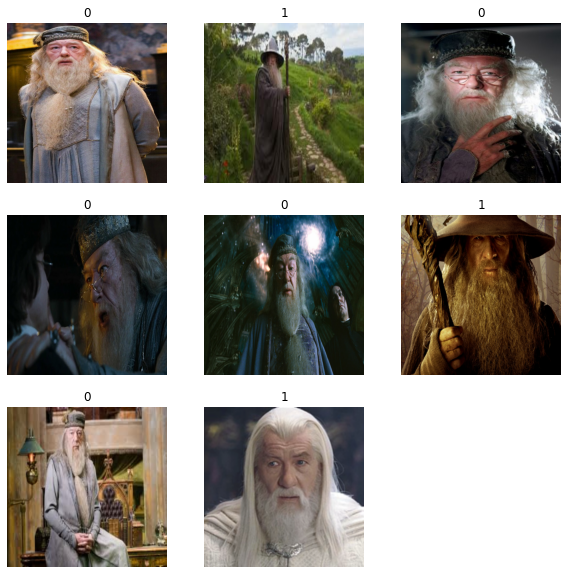

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Data Augmentation

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.RandomCrop(IMG_SIZE, IMG_SIZE),
        layers.RandomTranslation(height_factor = 0.1, width_factor = 0.1),
        #layers.CenterCrop(150,150),
        #layers.RandomContrast(0.1)
        #layers.RandomZoom((0.2,0.3), seed = SEED)
        #layers.Rescaling(1.0 / 255)
    ]
)

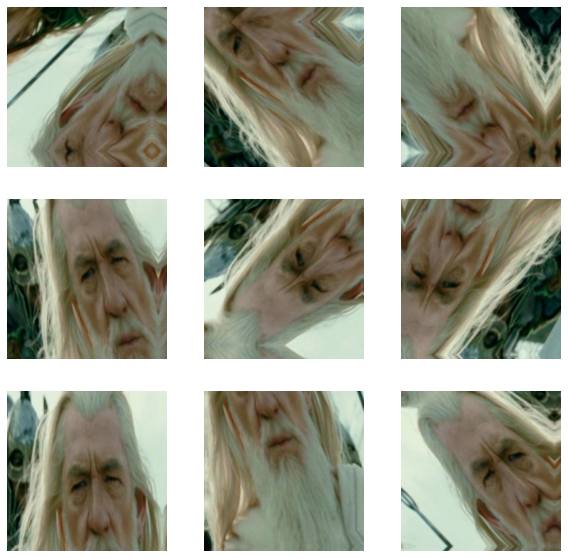

In [7]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Configuring the dataset for performance

In [8]:
#train_ds = train_ds.prefetch(buffer_size=32)
#val_ds = val_ds.prefetch(buffer_size=32)

NUM_CLASSES = 2

# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


train_ds = train_ds.map(
    input_preprocess
)

train_ds = train_ds.prefetch(buffer_size=32)

val_ds = val_ds.map(input_preprocess)
val_ds = val_ds.prefetch(buffer_size=32)

## Build the model

This model takes input images of shape (224, 224, 3), and the input data should range [0, 255]. Normalization is included as part of the model.

In [9]:
from tensorflow.keras.applications import EfficientNetB0

#model = EfficientNetB0(include_top=False, weights='imagenet', drop_connect_rate=0.4)

In [14]:
#Definimos las capas

def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE_READ, IMG_SIZE_READ, 3))
    x = data_augmentation(inputs)
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

model = build_model(num_classes=NUM_CLASSES)

## Training

In [11]:
epochs = 50  # @param {type: "slider", min:10, max:100}
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=2)

Epoch 1/50
8/8 - 11s - loss: 1.2083 - accuracy: 0.6875 - val_loss: 1.8020 - val_accuracy: 0.4375 - 11s/epoch - 1s/step
Epoch 2/50
8/8 - 1s - loss: 1.2065 - accuracy: 0.7969 - val_loss: 1.2801 - val_accuracy: 0.5000 - 1s/epoch - 135ms/step
Epoch 3/50
8/8 - 1s - loss: 0.7059 - accuracy: 0.7969 - val_loss: 1.1164 - val_accuracy: 0.6250 - 968ms/epoch - 121ms/step
Epoch 4/50
8/8 - 1s - loss: 0.6368 - accuracy: 0.8438 - val_loss: 1.2471 - val_accuracy: 0.6250 - 989ms/epoch - 124ms/step
Epoch 5/50
8/8 - 1s - loss: 1.1657 - accuracy: 0.7812 - val_loss: 1.4644 - val_accuracy: 0.6250 - 954ms/epoch - 119ms/step
Epoch 6/50
8/8 - 1s - loss: 0.8396 - accuracy: 0.7500 - val_loss: 2.2897 - val_accuracy: 0.6875 - 975ms/epoch - 122ms/step
Epoch 7/50
8/8 - 1s - loss: 0.8223 - accuracy: 0.8438 - val_loss: 1.6238 - val_accuracy: 0.5625 - 971ms/epoch - 121ms/step
Epoch 8/50
8/8 - 1s - loss: 1.1921 - accuracy: 0.7969 - val_loss: 1.9030 - val_accuracy: 0.6250 - 976ms/epoch - 122ms/step
Epoch 9/50
8/8 - 1s - l

In [15]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

unfreeze_model(model)

In [16]:
epochs = 45  # @param {type: "slider", min:8, max:50}
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=2)

Epoch 1/45
8/8 - 9s - loss: 0.9506 - accuracy: 0.6094 - val_loss: 0.6824 - val_accuracy: 0.5625 - 9s/epoch - 1s/step
Epoch 2/45
8/8 - 1s - loss: 0.8038 - accuracy: 0.6562 - val_loss: 0.6386 - val_accuracy: 0.6875 - 1s/epoch - 131ms/step
Epoch 3/45
8/8 - 1s - loss: 0.5699 - accuracy: 0.7031 - val_loss: 0.6085 - val_accuracy: 0.6875 - 988ms/epoch - 124ms/step
Epoch 4/45
8/8 - 1s - loss: 0.7160 - accuracy: 0.6875 - val_loss: 0.5883 - val_accuracy: 0.7500 - 973ms/epoch - 122ms/step
Epoch 5/45
8/8 - 1s - loss: 0.6308 - accuracy: 0.6875 - val_loss: 0.5707 - val_accuracy: 0.7500 - 972ms/epoch - 121ms/step
Epoch 6/45
8/8 - 1s - loss: 0.4987 - accuracy: 0.7969 - val_loss: 0.5643 - val_accuracy: 0.7500 - 990ms/epoch - 124ms/step
Epoch 7/45
8/8 - 1s - loss: 0.4406 - accuracy: 0.7656 - val_loss: 0.5433 - val_accuracy: 0.7500 - 975ms/epoch - 122ms/step
Epoch 8/45
8/8 - 1s - loss: 0.5473 - accuracy: 0.7812 - val_loss: 0.5305 - val_accuracy: 0.7500 - 989ms/epoch - 124ms/step
Epoch 9/45
8/8 - 1s - los

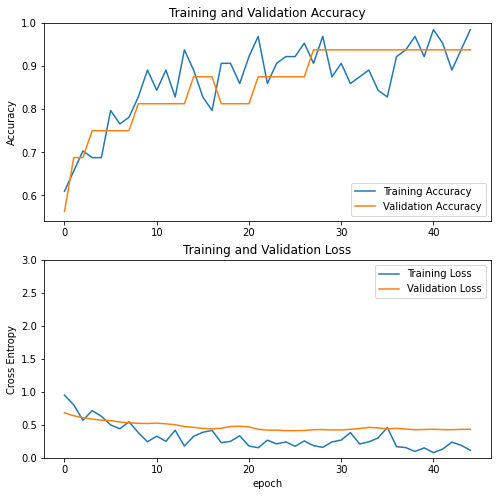

In [17]:
# Plot loss and accuracy history
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [18]:
model.save('EfficientNetB0.h5')